In [1]:
import pandas as pd
from os import path
from matplotlib import pyplot as plt
import seaborn as sns

## Setup

In [2]:
base_path = r"data"

events = pd.read_csv(path.join(base_path, r"spond__events.csv"))
exchange = pd.read_csv(path.join(base_path, r"spond__exchange_rates.csv"))
memberships = pd.read_csv(path.join(base_path, r"spond__memberships.csv"))
teams = pd.read_csv(path.join(base_path, r"spond__teams.csv"))
payments = pd.read_csv(path.join(base_path, r"spond_payments.csv"))

data = {"events":events, "exchange":exchange, "memberships":memberships, "teams":teams, "payments":payments}

## Data cleaning and data preprocessing

In [3]:

# Calculates event length in hours.
events["event_start"] = pd.to_datetime(events["event_start"])
# We consider events in the week that they start, this is to make sure that long running events make teams that are not actually active look more active than they are.
events["week"] = events["event_start"].dt.isocalendar().week
events["event_end"] = pd.to_datetime(events["event_end"])
events["event_length"] = (events["event_end"] - events["event_start"]).dt.total_seconds()/3600.0
events["ones"] = 1
print(f'Events range: {events["event_start"].min()} - {events["event_start"].max()}')


exchange["date"] = pd.to_datetime(exchange["date"])

payments["date"] = pd.to_datetime(pd.to_datetime(payments["created_at"]).dt.date)
payments["week"] = payments["date"].dt.isocalendar().week
payments["ones"] = 1
print(f'Payments range: {payments["date"].min()} - {payments["date"].max()}')

teams["created_at"] = pd.to_datetime(pd.to_datetime(teams["created_at"]).dt.date)
# Computes age of team at the end of the year in weeks
teams["age_weeks"] = (pd.Timestamp(year=2024, month=12, day=31) - teams["created_at"]).dt.total_seconds()/(60.0*60.0*24.0*7.0)


# Converts all payments to NOK
exchange = exchange.sort_values(["date" ,"currency"])
payments = payments.sort_values(["date" ,"currency"])
converted_payments = pd.merge_asof(
    payments,
    exchange,
    by='currency',
    left_on='date',
    right_on='date',
    direction='nearest'
)
converted_payments["volume_NOK"] = converted_payments["volume_local_currency"]/converted_payments["exchange_rate"]



events_per_team = events.groupby("team_id")["ones"].sum().reset_index()
events_per_team = pd.merge(events_per_team, teams, how="inner", on="team_id")
events_per_team = events_per_team.rename(columns={"ones":"Event count"})


teams["team_activity"].value_counts()

Events range: 2024-01-03 14:49:00+00:00 - 2024-12-31 21:00:00+00:00
Payments range: 2024-01-03 00:00:00 - 2024-12-31 00:00:00


team_activity
football             1800
cricket               355
netball               240
basketball            163
rugby                 163
gymnastics            101
other_non_sports      100
volleyball             79
dancing_and_cheer      79
pickleball             79
other_sports           78
social                 77
handball               72
field_hockey           71
music                  63
school                 56
tennis                 50
cycling                43
ice_hockey             38
badminton              37
martial_arts           36
multisport             33
volunteering           32
running                28
scouting               24
swimming               23
padel                  20
water_sports           20
golf                   20
rowing                 16
pingpong               14
squash                 14
baseball               14
softball               13
athletics              12
american_football      11
esports                11
alpine_skiing          1

In [4]:
for (table_name, table) in data.items():
    print(f"NAN counts for {table_name}")
    for col in table.columns:
        na_count = table[col].isna().sum()
        na_perc = na_count/table[col].size
        print(f"Column {col}: {na_count} ({100*na_perc:.2f}%)")
    print("")
    dupes = table.duplicated().sum()
    print(f"Duplicate rows for {table_name}: {dupes}")
    print("")


NAN counts for events
Column event_id: 0 (0.00%)
Column team_id: 0 (0.00%)
Column event_start: 0 (0.00%)
Column event_end: 0 (0.00%)
Column latitude: 38517 (26.94%)
Column longitude: 38517 (26.94%)
Column created_at: 0 (0.00%)
Column week: 0 (0.00%)
Column event_length: 0 (0.00%)
Column ones: 0 (0.00%)

Duplicate rows for events: 0

NAN counts for exchange
Column date: 0 (0.00%)
Column currency: 0 (0.00%)
Column exchange_rate: 0 (0.00%)

Duplicate rows for exchange: 0

NAN counts for memberships
Column membership_id: 0 (0.00%)
Column group_id: 0 (0.00%)
Column role_title: 0 (0.00%)
Column joined_at: 0 (0.00%)

Duplicate rows for memberships: 0

NAN counts for teams
Column team_id: 0 (0.00%)
Column team_activity: 0 (0.00%)
Column country_code: 0 (0.00%)
Column created_at: 0 (0.00%)
Column age_weeks: 0 (0.00%)

Duplicate rows for teams: 0

NAN counts for payments
Column payment_id: 0 (0.00%)
Column membership_id: 625 (0.25%)
Column team_id: 0 (0.00%)
Column currency: 0 (0.00%)
Column vol

### Comments on data cleaning

We see that data is mainly missing for the latitude and longitude of the events as well as a few membership ids. Since these columns will probably not be used much we can keep these datapoints for now.

## KPIs

#### Assumptions

Assuming here that groups here refer to teams.

### 1. Activation

#### Percentage of teams who use events or payments features

This metric is what percentage of registered teams have either created atleast one event or had one payment connected to them. This metric will tell us how likely a team that has registered for Spond is to try one of the features Spond has. The reason for considering teams who have used either one event or one payment is that for some teams only one of the features may be relevant to them.
We can compute this value by matching the team ids from the event table and the payment table against the team ids in the teams table. Then we can sum up the number of appearances of each team id in both tables and check how many of them are above zero. Then we divide this count by how many teams we are looking at in total.


### 2. Keep-using behavior

This metric will be a metric showing the average weekly retention rate. It will take all the teams that were active one week and count what percentage of them were also active the next week. This will then be computed for all the weeks where we have events or payments and averaged. The metric can also be filtered to only look at a subset of the teams.
The reason for choosing this metric is that we want to only look at the correlation between a team being active one week and being active in the future. We don't want for instance the growth of total number of active teams to have an impact on this metric, which is why this metric was chosen over something like a week-by-week growth rate of active teams.

To compute this metric we would make a table with columns indicating a week and rows being teams and then the elements in the table indicating whether a team was active that week or not. Then we can make a new table using a sliding window where we check if there is a team was active one week and the next week, and then count how many of these we have for each week. We can then count the number of active teams per week and divide the previous number on this number, which will give us for each week a percentage telling us how many of the active teams one week was also active the next.

### 3. Engagement depth

This metric will count average number of events teams have per week. This will give an indication of how often teams use the events feature and may reveal something about the type of usage for different groups of teams. For example some may have a high weekly average due to using the events feature for weekly trainings and such while other types of teams may only use the events feature for rarer events such as social group gatherings or irregular tournaments.

This metric will be computed by making a table with the weeks as the columns and the teams as the rows, with the elements of the table being how many events a team had in a certain week. Then we can take the average across all columns to get the average number of events per week for each team and then take the average across all the teams to get the final metric.

### 4. Monetization

For this metric we want to look primarily at the payments feature and figure out how much revenue the average team generates in an average week. This will give us insight into how much different types of teams use the payment feature and which types of teams will be most relevant to focus on when trying to increase revenue.

To compute this metric we will gather up and sum all payments a team has for each week. Then we will sum up the weekly volume for each team for all the weeks and divide by how long each team has been registered for the year. That data can then be averaged over the teams and multiplied by 0.02 to get how much weekly revenue a team generates on average.

### KPI Calculations

The two metrics chosen are the one for the keep-using behaviour and the one for the monetization.

In [5]:

def compute_keep_using(teams=teams, events=events, payments=payments):   

    activity_events = events.pivot_table(
        index="team_id",
        columns="week",
        values="ones",
        aggfunc="sum"
    ).fillna(0)
    activity_events = activity_events.loc[activity_events.index.isin(teams["team_id"])]
    activity_payments = payments.pivot_table(
        index="team_id",
        columns="week",
        values="ones",
        aggfunc="sum"
    ).fillna(0)
    activity_payments = activity_payments.loc[activity_payments.index.isin(teams["team_id"])]

    total_activity = activity_events.add(activity_payments, fill_value=0)

    total_activity.reindex(teams["team_id"], fill_value=0)

    # Table for whether a team is active in any given week.
    total_activity = total_activity >0.0

    active_next_week = total_activity.copy()

    for col in total_activity.columns[:-1]:
        active_next_week[col] = active_next_week[col] & active_next_week[col+1]

    retention = (active_next_week.sum(axis=0)/total_activity.sum(axis=0))[:-1]

    return retention.mean()

print(compute_keep_using())
print(compute_keep_using(teams=teams.loc[teams["team_activity"] == "football"]))

0.829468778384992
0.8539450366147447


#### Comments on keep-using metric

It might be more valuable to look at a longer window for clubs staying active. The metric used here might vary quite a bit if teams have a more sporadic schedule, while still using the app.

In [6]:
def compute_revenue(teams=teams, converted_payments=converted_payments):
    """
    Computes the average weekly revenue Spond recieves from the average team.
    """

    payments_per_team = converted_payments.groupby("team_id")["volume_NOK"].sum().reset_index()
    payments_per_team = pd.merge(payments_per_team, teams, how="inner", on="team_id")
    payments_per_team["weekly_volume"] = payments_per_team["volume_NOK"]/payments_per_team["age_weeks"]
    # payments_per_team["weekly_volume"].plot.hist(bins=100, xlim=(0, 4000))
    return payments_per_team["weekly_volume"].mean()*0.02

print(compute_revenue())



11.530316721713271


### Findings with KPIs

In [7]:
teams["country_code"].value_counts()

country_code
GBR    2993
NOR     969
USA     180
DEU      40
Name: count, dtype: int64

C:\Users\Eirik\AppData\Local\Temp\ipykernel_15092\1042753565.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_countries, x='Country', y='Weekly retention percentage', ax=axs[0], palette='tab10')
C:\Users\Eirik\AppData\Local\Temp\ipykernel_15092\1042753565.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_activities, x='Activity', y='Weekly retention percentage', ax=axs[1], palette='Set2')


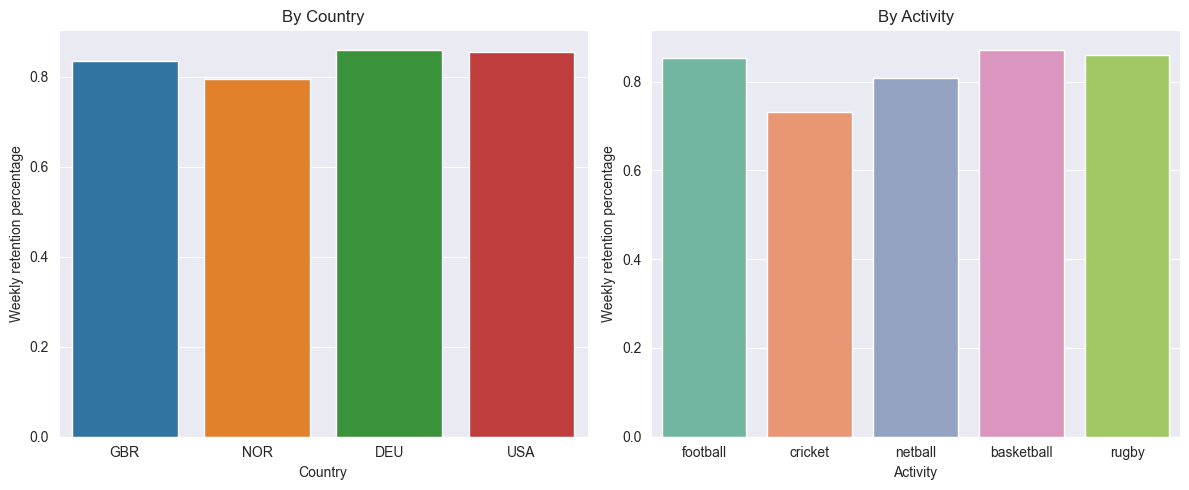

In [8]:
country_names = teams["country_code"].unique()
KU_countries = []

for country in country_names:
    KU_countries.append(compute_keep_using(teams=teams.loc[teams["country_code"] == country]))

activity_names = teams["team_activity"].value_counts().index.to_list()[:5]
KU_activities = []

for act in activity_names:
    KU_activities.append(compute_keep_using(teams=teams.loc[teams["team_activity"] == act]))

df_countries = pd.DataFrame({'Country': country_names, 'Weekly retention percentage': KU_countries})
df_activities = pd.DataFrame({'Activity': activity_names, 'Weekly retention percentage': KU_activities})

sns.set_style('darkgrid')
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Countries barplot
sns.barplot(data=df_countries, x='Country', y='Weekly retention percentage', ax=axs[0], palette='tab10')
axs[0].set_title('By Country')

# Activities barplot
sns.barplot(data=df_activities, x='Activity', y='Weekly retention percentage', ax=axs[1], palette='Set2')
axs[1].set_title('By Activity')

plt.tight_layout()
plt.show()

C:\Users\Eirik\AppData\Local\Temp\ipykernel_15092\991833519.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_countries, x='Country', y='Weekly revenue per team, NOK', ax=axs[0], palette='tab10')
C:\Users\Eirik\AppData\Local\Temp\ipykernel_15092\991833519.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_activities, x='Activity', y='Weekly revenue per team, NOK', ax=axs[1], palette='Set2')


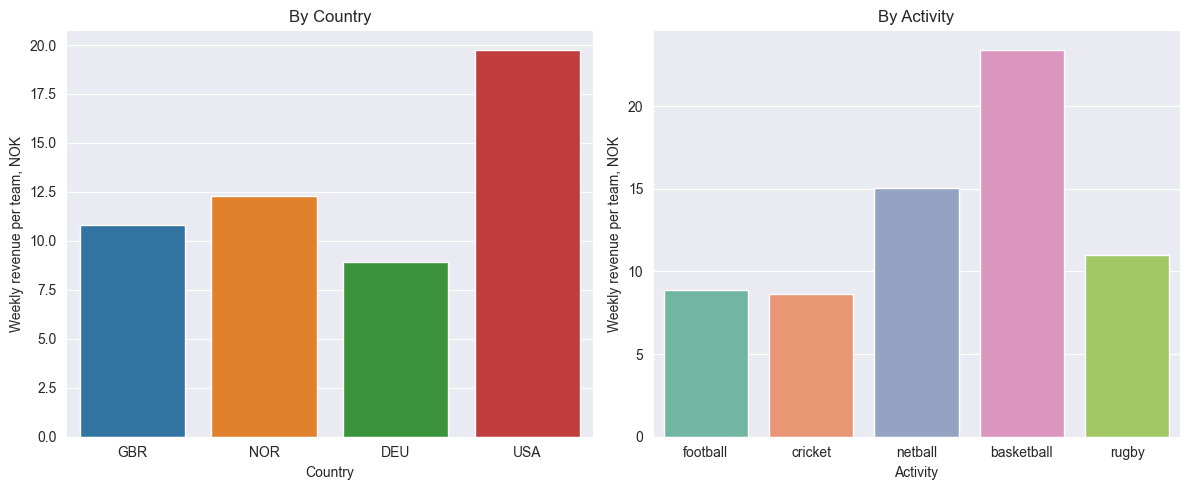

In [9]:
country_names = teams["country_code"].unique()
R_countries = []

for country in country_names:
    R_countries.append(compute_revenue(teams=teams.loc[teams["country_code"] == country]))

activity_names = teams["team_activity"].value_counts().index.to_list()[:5]
R_activities = []

for act in activity_names:
    R_activities.append(compute_revenue(teams=teams.loc[teams["team_activity"] == act]))

df_countries = pd.DataFrame({'Country': country_names, 'Weekly revenue per team, NOK': R_countries})
df_activities = pd.DataFrame({'Activity': activity_names, 'Weekly revenue per team, NOK': R_activities})

sns.set_style('darkgrid')
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Countries barplot
sns.barplot(data=df_countries, x='Country', y='Weekly revenue per team, NOK', ax=axs[0], palette='tab10')
axs[0].set_title('By Country')

# Activities barplot
sns.barplot(data=df_activities, x='Activity', y='Weekly revenue per team, NOK', ax=axs[1], palette='Set2')
axs[1].set_title('By Activity')

plt.tight_layout()
plt.show()

In [10]:
print(teams.loc[teams["country_code"] == "USA"]["team_activity"].value_counts())
print("")
print(teams.loc[teams["team_activity"] == "basketball"]["country_code"].value_counts())

team_activity
football             99
basketball           17
scouting              8
other_sports          8
softball              8
baseball              5
dancing_and_cheer     5
tennis                4
pickleball            4
social                4
ice_hockey            3
gymnastics            3
other_non_sports      2
american_football     2
rugby                 2
volleyball            2
figureskating         1
shooting_sports       1
handball              1
school                1
Name: count, dtype: int64

country_code
GBR    135
USA     17
NOR     11
Name: count, dtype: int64


C:\Users\Eirik\AppData\Local\Temp\ipykernel_15092\2063236496.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_EC, x='Event count', y='Weekly revenue per team, NOK', ax=axs, palette='tab10')


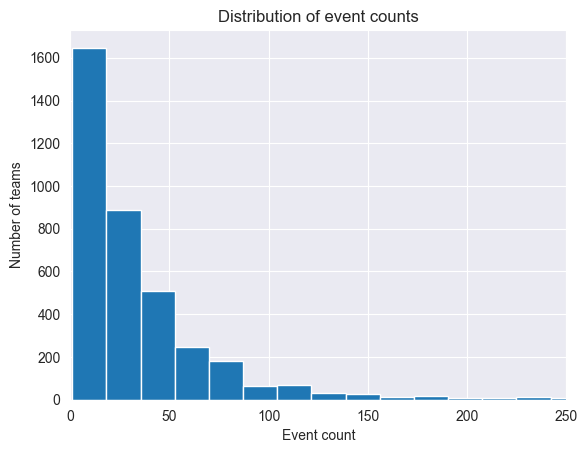

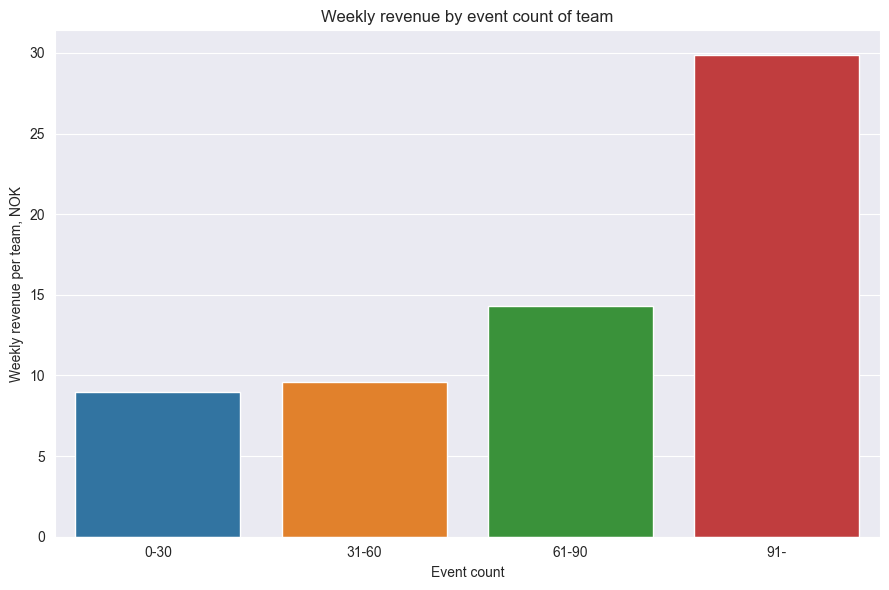

In [11]:
events_per_team["Event count"].plot.hist(bins=100, xlim=(0, 250), xlabel="Event count", ylabel="Number of teams", title="Distribution of event counts")

event_count_range = ["0-30", "31-60", "61-90", "91-"]
event_count_range_num = [(0, 30), (31, 60), (61, 90), (90, events_per_team["Event count"].max())]
R_event_counts = []

for i in range(len(event_count_range)):
    R_event_counts.append(compute_revenue(teams=events_per_team.loc[(events_per_team["Event count"] >= event_count_range_num[i][0]) & (events_per_team["Event count"] <= event_count_range_num[i][1])]))

df_EC = pd.DataFrame({'Event count': event_count_range, 'Weekly revenue per team, NOK': R_event_counts})

sns.set_style('darkgrid')
fig, axs = plt.subplots(1, 1, figsize=(9, 6))

# Event count barplot
sns.barplot(data=df_EC, x='Event count', y='Weekly revenue per team, NOK', ax=axs, palette='tab10')
axs.set_title('Weekly revenue by event count of team')

plt.tight_layout()
plt.show()

C:\Users\Eirik\AppData\Local\Temp\ipykernel_15092\4156292315.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_EC, x='Event count', y='Weekly retention percentage', ax=axs, palette='tab10')


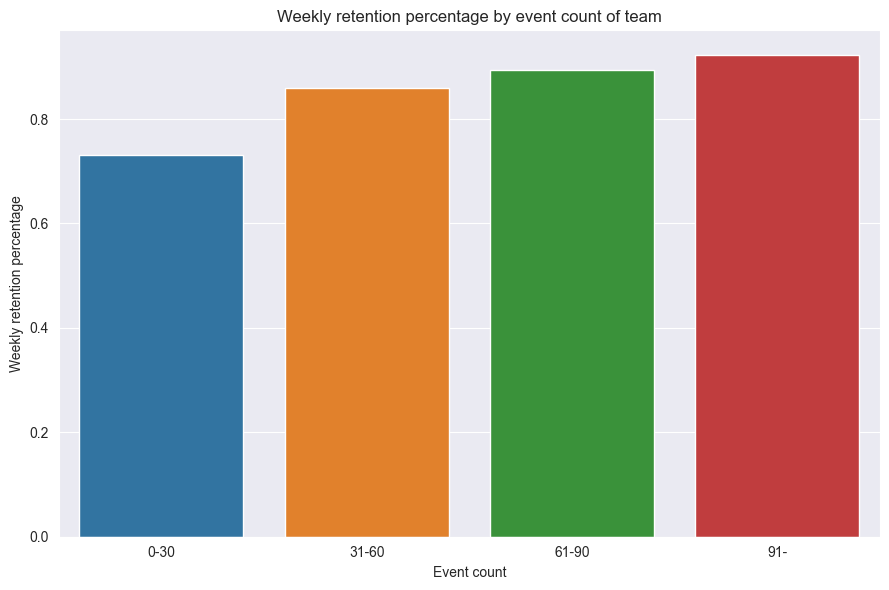

In [12]:
event_count_range = ["0-30", "31-60", "61-90", "91-"]
event_count_range_num = [(0, 30), (31, 60), (61, 90), (90, events_per_team["Event count"].max())]
KU_event_counts = []

for i in range(len(event_count_range)):
    KU_event_counts.append(compute_keep_using(teams=events_per_team.loc[(events_per_team["Event count"] >= event_count_range_num[i][0]) & (events_per_team["Event count"] <= event_count_range_num[i][1])]))

df_EC = pd.DataFrame({'Event count': event_count_range, 'Weekly retention percentage': KU_event_counts})

sns.set_style('darkgrid')
fig, axs = plt.subplots(1, 1, figsize=(9, 6))

# Countries barplot
sns.barplot(data=df_EC, x='Event count', y='Weekly retention percentage', ax=axs, palette='tab10')
axs.set_title('Weekly retention percentage by event count of team')

plt.tight_layout()
plt.show()

### Product implications

We see that the retention is fairly similar across different countries. However we see that when looking at the top 5 groups of team activities that there is a significant drop in the retention of cricket teams. This might indicate that there is some functionality that is missing for the cricket teams that make them use the app less over time than the other activities. It would therefore be good to investigate further what causes this difference in retention from the other sports and since cricket is the second biggest activity group this would likely be a good investment of time.

Furthermore we see a significant differences in weekly revenue per team for the different countries and activities. The biggest outliers here are the USA market, where each team generates significantly more revenue than other countries and the basketball activity where the revenue is also significantly higher. We see from the value counts that these could be separate phenomena since the main sport in the USA is football and that most of the basketball teams are from Great Britain. This would make focusing on both expanding usage in the US and expanding usage for basketball teams a worthwhile investment for the product team.

Thirdly we see a correlation where teams that have more events are also generally teams that generate a lot of revenue for the application. This suggests that making teams use the events feature may make them more likely to also use the other features of the app, such as the payments feature which generate revenue for Spond. Because of this it might make sense to find ways to make teams use the events feature more frequently even though it does not directly generate revenue for Spond.